<a href="https://colab.research.google.com/github/ju-ki/pytorch_basic/blob/master/dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DataLoader

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
mnist_train = MNIST("./data", train=True, download=True,
                    transform=transforms.ToTensor())
mnist_test = MNIST("./data", train=False, download=True,
                   transform=transforms.ToTensor())
print("訓練データの数:", len(mnist_train), "テストデータの数:", len(mnist_test))

img_size = 28
batch_size = 256
train_loader = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(mnist_test, batch_size=batch_size,
                          shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
訓練データの数: 60000 テストデータの数: 10000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(img_size*img_size, 1024)#Linearで全結合
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)

  def forward(self, x):
    x = x.view(-1, img_size*img_size)#-1と設定することで自動で行数を設定してくれる
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
net.cuda()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [9]:
from torch import optim
loss_fnc = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.01)

record_loss_train = []
record_loss_test = []

for i in range(10):
  net.train()
  loss_train = 0
  for j, (x,t) in enumerate(train_loader):
    x, t = x.cuda(), t.cuda()
    y = net(x)
    loss = loss_fnc(y, t)
    loss_train += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_train /= j + 1
  record_loss_train.append(loss_train)

  net.eval()
  loss_test = 0
  for j, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()
    y = net(x)
    loss = loss_fnc(y, t)
    loss_test += loss.item()
  loss_test /= j + 1
  record_loss_test.append(loss_test)

  if i %1 == 0:
    print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 2.2170084172106805 Loss_Test: 2.091237336397171
Epoch: 1 Loss_Train: 1.8275328392678118 Loss_Test: 1.4456750750541687
Epoch: 2 Loss_Train: 1.123870442522333 Loss_Test: 0.8428492963314056
Epoch: 3 Loss_Train: 0.7354263209282084 Loss_Test: 0.6129880599677563
Epoch: 4 Loss_Train: 0.5757219243556895 Loss_Test: 0.504459660872817
Epoch: 5 Loss_Train: 0.4919009974662294 Loss_Test: 0.44146817550063133
Epoch: 6 Loss_Train: 0.44096286474390234 Loss_Test: 0.4008821232244372
Epoch: 7 Loss_Train: 0.40695217454687077 Loss_Test: 0.37284814529120924
Epoch: 8 Loss_Train: 0.38295741658261484 Loss_Test: 0.35378920175135137
Epoch: 9 Loss_Train: 0.3638189818630827 Loss_Test: 0.3378458104096353


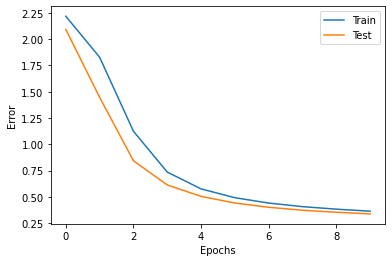

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [12]:
correct = 0
total = 0
for i, (x, t) in enumerate(test_loader):
  x, t = x.cuda(), t.cuda()
  x = x.view(-1, img_size*img_size)
  y = net(x)
  correct += (y.argmax(1) == t).sum().item()
  total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 90.35%
